# Assignment 2
## Dropout

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [4]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


## Dropout forward pass

In [6]:
## 测试一下 dropout

x = np.random.randn(500, 500) + 10
for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'train', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output', out.mean())
    print('Mean of test_time output', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test_time output set to zero: ', (out_test == 0).mean())
    print('\n')

Running tests with p =  0.3
Mean of input:  10.002723688396175
Mean of train-time output 9.998352180078317
Mean of test_time output 10.012237160114063
Fraction of train-time output set to zero:  0.300292
Fraction of test_time output set to zero:  0.299268


Running tests with p =  0.6
Mean of input:  10.002723688396175
Mean of train-time output 9.975870825995962
Mean of test_time output 10.012359888489256
Fraction of train-time output set to zero:  0.601096
Fraction of test_time output set to zero:  0.599464


Running tests with p =  0.75
Mean of input:  10.002723688396175
Mean of train-time output 9.981248531985978
Mean of test_time output 10.011941647126799
Fraction of train-time output set to zero:  0.750548
Fraction of test_time output set to zero:  0.7498




## Dropout backward pass

In [7]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.8929055701040923e-11


## FC nets with Dropout

In [8]:

N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], 
                              input_dim=D, 
                              num_classes=C,
                              weight_scale=5e-2, 
                              dtype=np.float64,
                              dropout=dropout, 
                              seed=123)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print('\n')

Running check with dropout =  0
Initial loss:  2.3051948273987857
W1 relative error: 2.53e-07
W2 relative error: 1.50e-05
W3 relative error: 2.75e-07
b1 relative error: 2.94e-06
b2 relative error: 5.05e-08
b3 relative error: 1.17e-10


Running check with dropout =  0.25
Initial loss:  2.3052077546540826
W1 relative error: 2.61e-07
W2 relative error: 5.02e-07
W3 relative error: 4.46e-08
b1 relative error: 7.40e-08
b2 relative error: 7.15e-10
b3 relative error: 1.00e-10


Running check with dropout =  0.5
Initial loss:  2.3035667586595423
W1 relative error: 1.14e-06
W2 relative error: 1.85e-07
W3 relative error: 6.60e-09
b1 relative error: 7.72e-08
b2 relative error: 1.20e-09
b3 relative error: 1.46e-10




## Regularization experiment

我们在这节的实验中训练一对神经网络：一个不使用 dropout，一个使用 0.75 的 dropout

In [9]:
num_train = 500
small_data = {'X_train': data['X_train'][:num_train],
              'y_train': data['y_train'][:num_train],
              'X_val': data['X_val'],
              'y_val': data['y_val'],}

solvers = {}
dropout_choices = [0, 0.25, 0.5, 0.75, 0.8, 0.9, 0.99]
for dropout in dropout_choices:
    model = FullyConnectedNet([500], dropout=dropout)
    print(dropout)

    solver = Solver(model, 
                    small_data,
                    num_epochs=25, batch_size=100,
                    update_rule='adam',
                    optim_config={'learning_rate': 5e-4,},
                    verbose=True,
                    print_every=100)
    solver.train()
    solvers[dropout] = solver

0
(Iteration 1 / 125) loss: 8.596245
(Epoch 0 / 25) train acc: 0.224000; val_acc: 0.183000
(Epoch 1 / 25) train acc: 0.382000; val_acc: 0.219000
(Epoch 2 / 25) train acc: 0.484000; val_acc: 0.248000
(Epoch 3 / 25) train acc: 0.620000; val_acc: 0.275000
(Epoch 4 / 25) train acc: 0.654000; val_acc: 0.245000
(Epoch 5 / 25) train acc: 0.726000; val_acc: 0.280000
(Epoch 6 / 25) train acc: 0.786000; val_acc: 0.301000
(Epoch 7 / 25) train acc: 0.812000; val_acc: 0.259000
(Epoch 8 / 25) train acc: 0.840000; val_acc: 0.269000
(Epoch 9 / 25) train acc: 0.908000; val_acc: 0.288000
(Epoch 10 / 25) train acc: 0.934000; val_acc: 0.295000
(Epoch 11 / 25) train acc: 0.960000; val_acc: 0.260000
(Epoch 12 / 25) train acc: 0.936000; val_acc: 0.270000
(Epoch 13 / 25) train acc: 0.952000; val_acc: 0.282000
(Epoch 14 / 25) train acc: 0.934000; val_acc: 0.257000
(Epoch 15 / 25) train acc: 0.972000; val_acc: 0.283000
(Epoch 16 / 25) train acc: 0.970000; val_acc: 0.292000
(Epoch 17 / 25) train acc: 0.964000; v

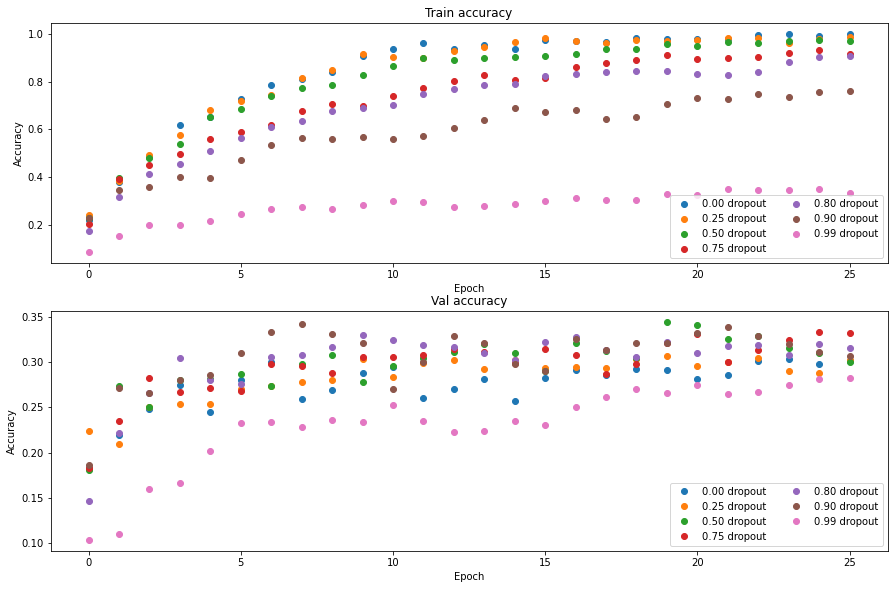

In [10]:
# 将上面结果可视化
train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

分析上面可视化的结果，是否有发现什么关于 dropout 的规律？

答：

dropout 避免了过拟合的问题。不使用 dropout 的模型，训练集准确率和验证集准确率之间的间隔会有 65% 多。使用 dropout 的模型，概率 p 的值越大，训练集准确率和验证集准确率之间的间隔就越小。但是，dropout 降低了模型的容量。过大的失活概率会使得网络并不能很好表达数据